# Fast deep sets with FLAX

In [Zaheer et al., NIPS 2017](https://arxiv.org/abs/1703.06114) Deep Sets are introduced, a new network architecture with interesting applications to particle physics. In particle physics, we often want to use mappings from events to numbers. For example, we could assign the label 1 if the event contained an interesting signal, and 0 otherwise. Each event contains a variable number of tracks. This is an obstacle for applying normal feed-forward networks, which cannot handle inputs of varying size.

Deep Sets can learn the mapping from a set of inputs to an output. The size of the set can vary from sample to sample. The architecture assumes that the mapping is invariant to permutations of the elements in the set. This is the case in the aforementioned example application. Although we could introduce an ordering over the set (for example, sort tracks along the momentum), such an ordering is arbitrary.

Mathematically, a Deep Set architecture consists of two feed forward networks $\rho$ and $\phi$ and a pooling operation invariant to permutations. One typically uses the sum, but other operations are possible, like the maximum,
$$
y(\{x\}) = \rho(\sum_i \phi_i(x_i)).
$$

Deep Sets are a very promising architecture, but implementing them in JAX / FLAX is a challenge. Here I show a fast implementation, the first that I am aware of, which is able to handle sets of variable length. Other implementations I found on GitHub only work for sets of constant size.

The main challenge to solve was to write the code in such a way that JAX can process input and output as tensors of fixed size. This is a requirement for the JIT compiler and to obtain a fast training loop. The compilation generally requires that all shapes are of fixed size, which contradicts the idea of passing sets of variable size to the network.

My solution consists of three parts.

## Efficient padding

JAX wants inputs of fixed size. We could decide to process one set at a time and pad the size of the set to the largest possible set. This would be wasteful in our application, however, because the track length distribution has a long tail. Most events have only few tracks but rarely an event has many tracks. Padding all events up to the largest size would be very inefficient.

My solution is to let the model process several events at once. To do this, I concatenate all the sets into a large contiguous block. This block can be padded to a fixed size. If the block is large enough, the sizes of different events average out, and we only need to pad a small fraction of the block size.

## Handling the sum

Next, we need to replace the sum, because it operates on a dynamically sized chunks, and we can't have those inside a JIT'ed function. My solution is to replace it with a matrix-vector product. All the inputs are in already one large block. We pass those in parallel to the first $\phi$ network. The output is another large block of latent vectors, one for each element in each set. To sum these over the original sets, I use matrices constructed like this one
$$
\begin{pmatrix}
1 & 1 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 \\
\end{pmatrix},
$$
which, when applied to a block with six vectors from three sets, computes the sum over the first set with three vectors, the second with two, and the third with one vector. The output are three latent vectors which are further processed in parallel by the second network. The summation matrix is also padded with zeros to match the input block. When finally the loss is computed, we discard the padded values by multiplying them with zeros.

## Using sparse matrices

The summation matrix is sparse. We use the experimental support for sparse matrices to speed up the computation. In this toy example, I observed a speedup by a factor of two.

The code below demonstrates these ideas on a toy example.

In [23]:
import jax
import jax.numpy as jnp
from jax.experimental import sparse
from flax import linen as nn
import numpy as np
import optax
from typing import Collection, Callable, Optional

# We generate some toy data, 1000 sets each with a size drawn from
# an exponential distribution. The maximum size is fixed to 400.
# Each set has elements which are vectors of size two.
rng = np.random.default_rng(1)

n = rng.exponential(size=100)
n *= 400 / np.max(n)
n += 1 # ensures that there are no empty events
n = n.astype(int)

X = [np.array(rng.uniform(size=(ni, 2)), dtype=np.float32) for ni in n]

# The mapping to learn is a non-linear function of the inputs. One can also
# replace np.mean with np.max or np.sum.
y = [np.mean(x[:, 0] ** 2 + 3 * x[:, 1]) ** 2 for x in X]


def prepare_data(X, y, padded_X_size, padded_y_size, dtype=np.float32):
    """
    Concatenates the input sets and pads inputs and outputs to fixed sizes.

    Returns padded arrays, the summation matrix, and a mask to undo the padding.
    """
    assert padded_y_size >= len(y)
    n = [len(x) for x in X]
    mask = np.zeros(padded_y_size, dtype=bool)
    mask[:len(y)] = 1
    assert padded_X_size >= np.sum(n)
    y = np.concatenate([y, np.zeros(padded_y_size - len(y), dtype=dtype)])
    X = np.concatenate(X, dtype=dtype)
    X = np.concatenate([X, np.zeros((padded_X_size - len(X),) + X.shape[1:], dtype=dtype)])
    indices = np.empty((np.sum(n), 2), dtype=int)
    a = 0
    for j, b in enumerate(np.cumsum(n)):
        indices[a:b, 0] = j
        indices[a:b, 1] = np.arange(a, b)
        a = b
    sum_matrix = sparse.BCOO(
        (np.ones(len(indices), dtype=np.int8), indices),
        shape=(padded_y_size, padded_X_size),
        indices_sorted=True, unique_indices=True)
    print(f"X fractional overhead {np.mean(np.sum(sum_matrix.todense(), axis=0) == 0):.2f}", )
    print(f"y fractional overhead {np.mean(~mask):.2f}")
    X = jnp.array(X)
    y = jnp.array(y)
    return X, y, sum_matrix, mask

X, y, sum_matrix, mask = prepare_data(X, y, 5_000, 1_000)

X fractional overhead 0.00
y fractional overhead 0.00


In [24]:
class MLP(nn.Module):
    nodes: Collection[int]
    nonlin: Callable
    output: Optional[int] = None

    @nn.compact
    def __call__(self, x):
        for size in self.nodes:
            x = nn.Dense(size)(x)
            x = self.nonlin(x)
        if self.output is not None:
            return nn.Dense(self.output)(x)
        return x

class Model(nn.Module):
    phi_nodes: Collection[int]
    rho_nodes: Collection[int]

    def setup(self):
        self.phi = MLP(self.phi_nodes, nn.relu)
        self.rho = MLP(self.rho_nodes, nn.relu, 1)

    @nn.compact
    def __call__(self, x, sum_matrix):
        x = self.phi(x)
        y = sum_matrix @ x
        y = self.rho(y)
        return y.flatten()

rng_key = jax.random.PRNGKey(0)

model = Model((128,) * 3, (128,) * 3)
theta = model.init(rng_key, X, sum_matrix)
# model.tabulate does not work with BCOO
# print(model.tabulate(rng_key, X, sum_matrix))

opt = optax.adam(learning_rate=1e-3)
opt_state = opt.init(theta)

@jax.jit
def loss_fn(theta, X, y, sum_matrix, mask):
    yp = model.apply(theta, X, sum_matrix)
    return jnp.mean(mask * (y - yp) ** 2)

@jax.jit
def step(theta, opt_state, X, y, sum_matrix, mask):
    loss, grad = jax.value_and_grad(loss_fn)(theta, X, y, sum_matrix, mask)
    updates, opt_state = opt.update(grad, opt_state)
    theta = optax.apply_updates(theta, updates)
    return loss, theta, opt_state

best_loss = np.inf
best_theta = theta
train_loss = []
for epoch in range(1, 5000):
    loss, theta, opt_state = step(theta, opt_state, X, y, sum_matrix, mask)
    train_loss.append(loss)
    if loss < best_loss:
        best_loss = loss
        best_theta = theta
        if best_loss < 0.01:
            break
    if epoch == 1 or epoch % 100 == 0:
        print(f"epoch = {epoch:5} loss = {train_loss[-1]:.2f}")

epoch =     1 loss = 16.48
epoch =   100 loss = 3.92
epoch =   200 loss = 0.76
epoch =   300 loss = 0.32
epoch =   400 loss = 0.25
epoch =   500 loss = 0.37
epoch =   600 loss = 0.16
epoch =   700 loss = 0.12
epoch =   800 loss = 0.15
epoch =   900 loss = 0.03
epoch =  1000 loss = 0.02


I plot the loss as a function of the epoch. Adam does a good job of minimizing the loss without further rate scheduling. I tried several other optimizers, Adam performed best out of those which worked (some optimizers from optax fail on this problem with an error message).

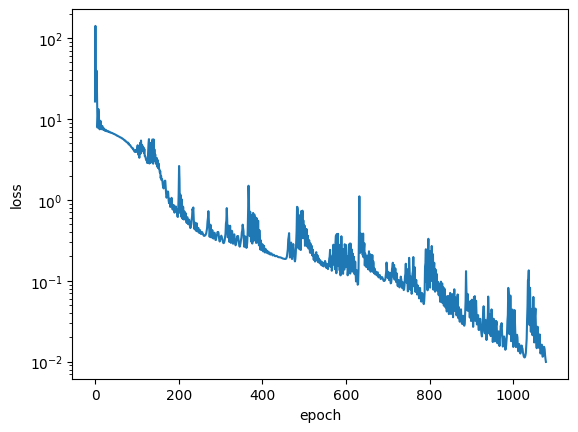

In [25]:
from matplotlib import pyplot as plt

yp = model.apply(best_theta, X, sum_matrix)
ym = y[mask]
ypm = yp[mask]

plt.figure()
plt.plot(train_loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.semilogy();

To show that the network managed to learn the mapping, I show the value obtained for each set and the prediction by the network (left-hand side) and the residuals (right-hand side).

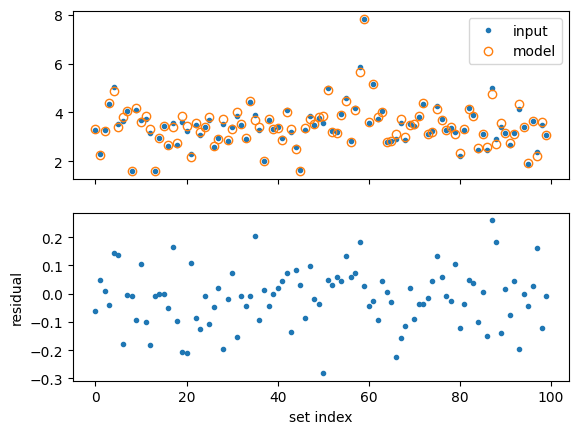

In [26]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=False)
ax[0].plot(ym, ".", label="input")
ax[0].plot(yp, "o", mfc="none", label="model")
ax[0].legend()
ax[1].plot(ym - ypm, ".")
ax[1].set_ylabel("residual")
ax[1].set_xlabel("set index");